# Tully-Fisher Secondary Target Sample

Demonstrate PostgreSQL access to the TF targets in the secondary target database at NERSC.

In [45]:
import os
import requests

from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import psycopg2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning = 0)

## Postgres Query

See if we have a cached copy of the query results (in FITS format) before running this query.

For connecting to the database, it is recommended that you store the password and connection port in a secure `.pgpass` file on the system, or create a private INI file that is not committed to GitHub. Connection details are not going to be saved in this notebook. Ask on the #timedomain-general or #peculiar-velocity slack channels for more information.

See the [database wiki page](https://desi.lbl.gov/trac/wiki/DESIDatabase) for information about the location and names of tables and their schema.

In [3]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('tf_targets.fits') and use_cached:
    tf_targets = Table.read('tf_targets.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()

        query = """SELECT DISTINCT pr.pvtype, pr.sga_id, fd.targetid, fd.target_ra, fd.target_dec, fd.tileid, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, zd.yyyymmdd
                    FROM fibermap_daily fd
                    INNER JOIN
                        zbest_daily zd ON zd.targetid = fd.targetid
                    INNER JOIN
                        (SELECT targetid, MAX(expid) AS max_expid
                            FROM fibermap_daily
                            GROUP BY targetid) groupfmap
                            ON fd.targetid = groupfmap.targetid AND fd.expid = groupfmap.max_expid
                    INNER JOIN
                        (SELECT targetid, MAX(yyyymmdd) AS max_date
                            FROM zbest_daily
                            GROUP BY targetid) groupzd
                            ON zd.targetid = groupzd.targetid AND zd.yyyymmdd = groupzd.max_date
                    INNER JOIN pv.proposals pr ON (CAST(pr.ra*10000 AS INTEGER) = CAST(fd.target_ra*10000 AS INTEGER)) AND
                                                  (CAST(pr.dec*10000 AS INTEGER) = CAST(fd.target_dec*10000 AS INTEGER))
                    WHERE (pr.pvtype LIKE 'TFT' or pr.pvtype LIKE 'EXT' or pr.pvtype LIKE 'SGA')
                    ORDER BY zd.yyyymmdd;"""

        cursor.execute(query)
        rows = cursor.fetchall()
        tf_targets = Table(list(map(list, zip(*rows))),
                           names=['PVTYPE', 'SGA_ID', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'TILEID', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN', 'YYYYMMDD'])
        tf_targets.write('tf_targets.fits', overwrite=True)
        
    except (Exception, psycopg2.Exception) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
tf_targets

PVTYPE,SGA_ID,TARGETID,TARGET_RA,TARGET_DEC,TILEID,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,YYYYMMDD
bytes3,int64,int64,float64,float64,int64,float64,float64,bytes6,float64,int64,int64
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,80611,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,80611,0.0349532879812339,6.64774044838025e-06,GALAXY,33952.1068879628,0,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,80611,0.046449435766605,2.88855814568856e-06,GALAXY,53137.0094233155,0,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,80611,0.0445682338630569,1.90017783907223e-06,GALAXY,33245.3577982187,0,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,80611,0.054035597680716,1.08280425883813e-05,GALAXY,11625.5793859102,0,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,80611,0.0296421307118722,5.19924224039755e-06,GALAXY,57099.7675513407,0,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,80611,0.0589073438874499,3.6126010927389e-06,GALAXY,12976.2707899213,0,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,80611,0.0339580769142768,4.84624800995257e-06,GALAXY,4275.01541189849,0,20201222
TFT,269195,39628462834585206,35.9738797902803,29.3592905954632,80611,-0.00199570145091582,4.13115987161332e-48,STAR,1.94266889222573e+84,1570,20201222


In [4]:
np.unique(tf_targets['PVTYPE'], return_counts=True)

(<Column name='PVTYPE' dtype='bytes3' length=3>
 EXT
 SGA
 TFT,
 array([  303,  6191, 19003]))

In [5]:
coma_cluster = ((tf_targets['TILEID'] <= 135) & (tf_targets['TILEID'] >= 109)) | ((tf_targets['TILEID'] <= 456) & (tf_targets['TILEID'] >= 454))
np.sum(coma_cluster)
tf_targets = tf_targets[coma_cluster]

## Plot Target Coordinates

In [6]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PVTYPE'])
    for class_name in class_names:
        select = table['PVTYPE'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['TARGET_RA'])
        _dec = np.radians(table[select]['TARGET_DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

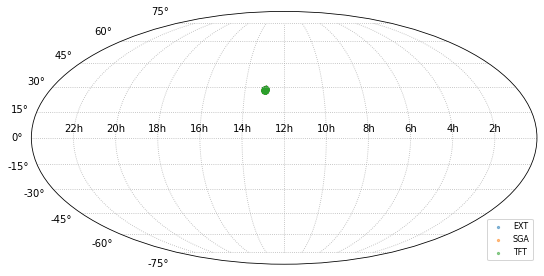

In [7]:
fig = plot_radec(tf_targets)

## Plot Target Redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [28]:
isgoodz = (tf_targets['DELTACHI2']>= 25) & (tf_targets['ZWARN']==0)
# isgoodz = tf_targets['ZWARN']==0
np.sum(isgoodz)

653

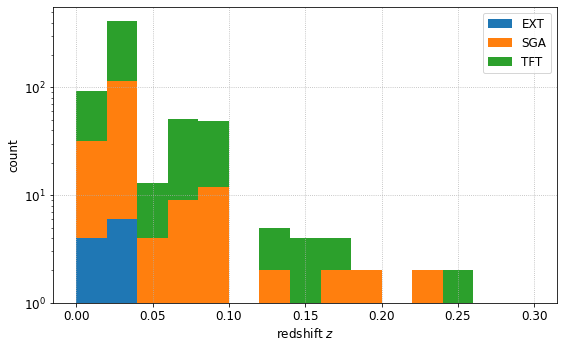

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_targets['PVTYPE'])
for pvtype in pvtypes:
    ispvtype = tf_targets['PVTYPE'] == pvtype
    zdata.append(list(tf_targets[isgoodz & ispvtype]['Z']))

zbins = np.linspace(0,0.3,16)
ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)
ax.set(#ylim=(0,15),
       xlabel='redshift $z$',
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

### Cheap Cut on Coma Redshifts

Redshift of coma cluster is *z*=0.0231. The velocity dispersion is 1000 km/s, implying

$$\Delta z = c/(1000~\mathrm{km/s}) \approx 0.003$$

So look for redshifts between 0.020 and 0.026.

In [35]:
zcoma = 0.0231
dzcoma = 0.003
nsigma = 2

isincoma = (tf_targets['Z'] > zcoma - nsigma*dzcoma) & (tf_targets['Z'] < zcoma + nsigma*dzcoma)
np.sum(isincoma & isgoodz)

426

## Select Good Reshifts with Unique TARGETIDs, in the Coma Cluster

In [36]:
select = isincoma & isgoodz

uniq_targ, uniq_targ_idx = np.unique(tf_targets[select]['TARGETID'], return_index=True)
tf_subtab = tf_targets[select][uniq_targ_idx]
tf_subtab

PVTYPE,SGA_ID,TARGETID,TARGET_RA,TARGET_DEC,TILEID,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,YYYYMMDD
bytes3,int64,int64,float64,float64,int64,float64,float64,bytes6,float64,int64,int64
TFT,566771,1070737989304335,194.668990081081,26.7582309400934,129,0.0246713966511429,6.60225791845131e-06,GALAXY,477.180004218593,0,20210509
TFT,98934,1070743378984983,194.209205227542,27.0906277907314,125,0.023765274311155,8.51553878167392e-05,GALAXY,88.3161086926411,0,20210504
TFT,366393,1070743387373570,194.659288499655,27.0140705777492,125,0.0231612739255744,1.5006324843651e-05,GALAXY,103.638622358441,0,20210504
TFT,824392,1070743391567889,195.013014748088,26.8912151792737,129,0.0192594428023064,7.00597188137199e-05,GALAXY,144.712430537562,0,20210509
TFT,824392,1070743391567890,195.016479603259,26.9049972167514,128,0.020470715694989,4.60043259637676e-05,GALAXY,87.2849818112154,0,20210507
TFT,819754,1070748764471298,194.11600974993,27.2898553378398,126,0.0248462736346038,6.20511587890926e-06,GALAXY,1096.89091672376,0,20210505
TFT,819754,1070748764471299,194.122172137543,27.2927447111501,129,0.0254188017092864,2.88042103508884e-06,GALAXY,2693.51984557509,0,20210509
TFT,302524,1070748764471304,194.143878522576,27.2295312975095,128,0.0237637303685378,1.85451476392641e-05,GALAXY,99.1433198386803,0,20210507
TFT,1144453,1070748768665618,194.576600469452,27.3120652676833,128,0.0243064723174717,4.02785335328157e-06,GALAXY,1593.3011129871,0,20210507


In [37]:
tf_subtab.write('tf_targets_coma_qcuts.fits', overwrite=True)

### Count SGA Galaxies with More than 1 Observation

In [38]:
ids, counts = np.unique(tf_subtab['SGA_ID'], return_counts=True)
ids[counts > 1]

8032
20886
23552
25532
30149
98934
100987
104579
122260
127141
171794


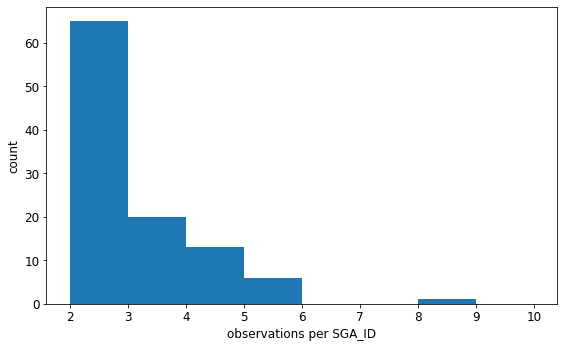

In [39]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)
ax.hist(counts[counts > 1], bins=np.linspace(2,10,9))
ax.set(xlabel='observations per SGA_ID',
       ylabel='count');

In [40]:
high_count_sga = np.in1d(tf_subtab['SGA_ID'], ids[counts > 1])
sga_subtab = tf_subtab[high_count_sga]
sga_subtab

PVTYPE,SGA_ID,TARGETID,TARGET_RA,TARGET_DEC,TILEID,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,YYYYMMDD
bytes3,int64,int64,float64,float64,int64,float64,float64,bytes6,float64,int64,int64
TFT,566771,1070737989304335,194.668990081081,26.7582309400934,129,0.0246713966511429,6.60225791845131e-06,GALAXY,477.180004218593,0,20210509
TFT,98934,1070743378984983,194.209205227542,27.0906277907314,125,0.023765274311155,8.51553878167392e-05,GALAXY,88.3161086926411,0,20210504
TFT,366393,1070743387373570,194.659288499655,27.0140705777492,125,0.0231612739255744,1.5006324843651e-05,GALAXY,103.638622358441,0,20210504
TFT,824392,1070743391567889,195.013014748088,26.8912151792737,129,0.0192594428023064,7.00597188137199e-05,GALAXY,144.712430537562,0,20210509
TFT,824392,1070743391567890,195.016479603259,26.9049972167514,128,0.020470715694989,4.60043259637676e-05,GALAXY,87.2849818112154,0,20210507
TFT,819754,1070748764471298,194.11600974993,27.2898553378398,126,0.0248462736346038,6.20511587890926e-06,GALAXY,1096.89091672376,0,20210505
TFT,819754,1070748764471299,194.122172137543,27.2927447111501,129,0.0254188017092864,2.88042103508884e-06,GALAXY,2693.51984557509,0,20210509
TFT,302524,1070748764471304,194.143878522576,27.2295312975095,128,0.0237637303685378,1.85451476392641e-05,GALAXY,99.1433198386803,0,20210507
TFT,1144453,1070748768665618,194.576600469452,27.3120652676833,128,0.0243064723174717,4.02785335328157e-06,GALAXY,1593.3011129871,0,20210507


In [41]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [42]:
sgacat = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE') 
sgacat

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [44]:
for sga_id in np.unique(sga_subtab['SGA_ID']):
    galaxy_list = sga_subtab[sga_subtab['SGA_ID'] == sga_id]
    
    # Total hack to find SGA target, because the PVTYPE can't be trusted.
    # Talk to an expert about actual SGA targets in DESI.
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) < 1:
        print('No galaxy for {}'.format(sga_id))
        continue
    if np.sum(is_sga_galaxy) > 1:
        print('Too many records for {}'.format(sga_id))
        continue
    
    targetid = sga_galaxy['TARGETID'][0]
    ra, dec = float(sga_galaxy['TARGET_RA']), float(sga_galaxy['TARGET_DEC'])
    
    # D26 in arcmin
    d26 = float(sgacat[sgacat['SGA_ID'] == sga_id]['D26'])
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
#     img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
#     img = mpl.image.imread(img_file)

#     fig = plt.figure(figsize=(7,5))

#     ax = fig.add_subplot(111, projection=wcs)
#     ax.imshow(np.flip(img, axis=0))
#     ax.set(xlabel='ra', ylabel='dec')
#     overlay = ax.get_coords_overlay('icrs')
#     overlay.grid(color='white', ls='dotted');

#     # Add the location of the SDSS and DESI fibers.
#     # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
#     r = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
#                      edgecolor='red', facecolor='none', alpha=0.8, lw=2,
#                      transform=ax.get_transform('icrs'))
#     ax.add_patch(r)

#     for tft in tf_list:
#         ra, dec = float(tft['TARGET_RA']), float(tft['TARGET_DEC'])
        
#         # Add the location of the SDSS and DESI fibers.
#         # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
#         r = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
#                          edgecolor='green', facecolor='none', alpha=0.8, lw=2,
#                          transform=ax.get_transform('icrs'))
#         ax.add_patch(r)
    
#     fig.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
#     fig.savefig('coma_tf_{}.png'.format(targetid), dpi=120)
    
#     fig.clear()
#     plt.close(fig)

No galaxy for 449306
No galaxy for 775774
